In [1]:
# Standard library imports
from typing import Any, List, Union

# Third-party library imports
import numpy as np
import pandas as pd
import shap
import sweetviz as sv
import mlflow.pyfunc
import lightgbm as lgb
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import os
import multiprocessing
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)

# Explainable Generic ML Pipeline with MLflow

One common challenge in MLOps is the hassle of migrating between various algorithms or frameworks. To tackle the challenge, below is the code demo for my second article on the topic of generic model building using mlflow.pyfunc, [link to the article published on Towards Data Science](https://medium.com/towards-data-science/explainable-generic-ml-pipeline-with-mlflow-2494ca1b3f96). 

While [the first article](https://medium.com/towards-data-science/algorithm-agnostic-model-building-with-mlflow-b106a5a29535) sets up a foundation for a minimalist generic model wrapper, in the code below, we will build a much more sophisticated ML pipeline with the below functionalities: 

* This pipeline supports both classification (binary) and regression tasks. It works with scikit-learn models and other algorithms that follow the scikit-learn interface (i.e., fit, predict, predict_proba).
* Incorporating a fully functional Pre-Processor that can be fitted on train data and then used to transform new data for model consumption. This pre-processor can handle both numeric and categorical features and handle missing values with various imputation strategies. 
* Adding an explainer to shed light on the model's reasoning, which is invaluable for model selection, monitoring and implementation. This task can be tricky due to the varying implementations of SHAP values across different ML algorithms. But, all good, we will address the challenge in this article. 😎

## A Pre-Processor

### Create A Custome Preprocessor 

In [27]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    Custom preprocessor for numeric features.
    
    - Handles scaling of numeric data
    - Performs imputation of missing values
    
    Attributes:
        transformer (Pipeline): Pipeline for numeric preprocessing
        features (List[str]): Names of input features
    """

    def __init__(self):
        """
        Initialize preprocessor.
        
        - Creates placeholder for transformer pipeline
        """
        self.transformer = None

    def fit(self, X, y=None):
        """
        Fits the transformer on the provided dataset.
        
        - Configures scaling for numeric features
        - Sets up imputation for missing values
        - Stores feature names for later use

        Parameters:
            X (pd.DataFrame): The input features to fit the transformer.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            PreProcessor: The fitted transformer instance.
        """
        self.features = X.columns.tolist()

        if self.features:
            self.transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
            self.transformer.fit(X[self.features])

        return self

    def transform(self, X):
        """
        Transform input data using fitted pipeline.
        
        - Applies scaling to numeric features
        - Handles missing values through imputation
        
        Parameters:
            X (pd.DataFrame): Input features to transform
        
        Returns:
            pd.DataFrame: Transformed data with scaled and imputed features
        """
        X_transformed = pd.DataFrame()

        if self.features:
            transformed_data = self.transformer.transform(X[self.features])
            X_transformed[self.features] = transformed_data

        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fits the transformer on the input data and then transforms it.

        Parameters:
            X (pd.DataFrame): The input features to fit and transform.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        self.fit(X, y)
        return self.transform(X)


In [28]:
# Set parameters for synthetic data
n_feature = 10
n_inform = 4
n_redundant = 0
n_samples = 1000

# Generate synthetic classification data
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_feature,
    n_informative=n_inform,
    n_redundant=n_redundant,
    shuffle=False,
    random_state=12
)

# Create feature names
feat_names = [f'inf_{i+1}' for i in range(n_inform)] + \
            [f'rand_{i+1}' for i in range(n_feature - n_inform)]

# Convert to DataFrame with named features
X = pd.DataFrame(X, columns=feat_names)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=22
)

In [4]:
# a quick look at the data using sweetviz
train_df = X_train.copy()
train_df['target'] = y_train
report = sv.analyze(train_df, target_feat='target')
report.show_html("svreports/synthetic_df_eda.html")

                                             |          | [  0%]   00:00 -> (? left)

Report svreports/synthetic_df_eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [29]:
# Test the preprocessor
preprocessor_v1 = PreProcessor() # define the preprocessor
X_train_transformed = preprocessor_v1.fit_transform(X_train)  # train the preprocessor on the train data
X_test_transformed = preprocessor_v1.transform(X_test) # apply the preprocessor on the new data

In [6]:
# sweetviz report on the preprocessed data for comparison and review
train_df_transformed = X_train_transformed.copy()
train_df_transformed['target'] = y_train
report = sv.analyze(train_df_transformed, target_feat='target')
report.show_html("svreports/synthetic_df_transformed_eda.html")

                                             |          | [  0%]   00:00 -> (? left)

Report svreports/synthetic_df_transformed_eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Utilize the Preprocessor in the PL Pipeline

Now let's utilize the preprocessor in the ML pipeline. 

In [30]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    Custom ML pipeline for classification and regression.
    
    - work with any scikit-learn compatible model
    - Combines preprocessing and model training
    - Handles model predictions
    - Compatible with MLflow tracking
    - Supports MLflow deployment

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance
        preprocessor (Any or None): Data preprocessing pipeline
        config (Any or None): Optional config for model settings 
        task(str): Type of ML task ('classification' or 'regression')
    """

    def __init__(self, model=None, preprocessor=None, config=None):
        """
        Initialize the ML_PIPELINE.
        
        Parameters:
            model (BaseEstimator, optional): 
                - Scikit-learn compatible model
                - Defaults to None
            
            preprocessor (Any, optional):
                - Transformer or pipeline for data preprocessing
                - Defaults to None
            
            config (Any, optional):
                - Additional model settings
                - Defaults to None
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config
        self.task = "classification" if hasattr(self.model, "predict_proba") else "regression"

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model on provided data.
        
        - Applies preprocessing to features
        - Fits model on transformed data
        
        Parameters:
            X_train (pd.DataFrame): Training features
            y_train (pd.Series): Target values
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(
            self, context: Any, model_input: pd.DataFrame
            ) -> np.ndarray:
        """
        Generate predictions using trained model.
        
        - Applies preprocessing to new data
        - Uses model to make predictions
        
        Parameters:
            context (Any): Optional context information provided 
                by MLflow during the prediction phase
            model_input (pd.DataFrame): Input features
        
        Returns:
            Any: Model predictions or probabilities
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        if self.task == "classification":
            prediction = self.model.predict_proba(processed_model_input)[:,1]
        elif self.task == "regression":
            prediction = self.model.predict(processed_model_input)
        return prediction

In [31]:
# define the ML pipeline instance
ml_pipeline = ML_PIPELINE(model = lgb.LGBMClassifier(verbose = -1),
                        #   model = RandomForestClassifier(), # to switch to another algorithm
                          preprocessor = PreProcessor())

In [32]:
# train the ML pipeline then use it for prediction
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context=None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc: {auc:.3f}")

auc: 0.975


### Easily Migrate to a Different Preprocessor

The above preprocessor has some room for improvement. For one, it doesn't handle categorical features. Let's

* create a more sophisticated preprocessor with the same API
* test switching preprocessor  to the ML pipeline (we shouldn't need to change a single line in the ML Pipeline class)

In [33]:
class PreProcessor_v2(BaseEstimator, TransformerMixin):
    """
    Custom transformer for data preprocessing.
    
    - Scales numeric features
    - Encodes categorical features
    - Handles missing values via imputation
    - Compatible with scikit-learn pipeline
    
    Attributes:
        num_impute_strategy (str): Numeric imputation strategy
        cat_impute_strategy (str): Categorical imputation strategy
        num_transformer (Pipeline): Numeric preprocessing pipeline
        cat_transformer (Pipeline): Categorical preprocessing pipeline
        transformed_cat_cols (List[str]): One-hot encoded column names
        num_features (List[str]): Numeric feature names
        cat_features (List[str]): Categorical feature names
    """

    def __init__(self, num_impute_strategy='median', 
                 cat_impute_strategy='most_frequent'):
        """
        Initialize the transformer.
        
        - Sets up numeric data transformer
        - Sets up categorical data transformer
        - Configures imputation strategies
        
        Parameters:
            num_impute_strategy (str): Strategy for numeric missing values
            cat_impute_strategy (str): Strategy for categorical missing values
        """
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy

    def fit(self, X, y=None):
        """
        Fit transformer on input data.
        
        - Identifies feature types
        - Configures feature scaling
        - Sets up encoding
        - Fits imputation strategies
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            CustomTransformer: Fitted transformer
        """
        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy)),
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Get transformed categorical column names.
        
        - Creates names after one-hot encoding
        - Combines category with encoded values
        
        Returns:
            List[str]: One-hot encoded column names
        """
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transform input data.
        
        - Applies fitted scaling
        - Applies fitted encoding
        - Handles numeric and categorical features
        
        Parameters:
            X (pd.DataFrame): Input features
        
        Returns:
            pd.DataFrame: Transformed data
        """
        X_transformed = pd.DataFrame()

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols)
            X_transformed = pd.concat([X_transformed, transformed_cat_df], axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fit and transform input data.
        
        - Fits transformer to data
        - Applies transformation
        - Combines both operations
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            pd.DataFrame: Transformed data
        """
        self.fit(X, y)
        return self.transform(X)

In [34]:
# add missings to the synthetic dataset
np.random.seed(42) 
missing_rate = 0.20 
n_missing = int(np.floor(missing_rate * X.size))
rows = np.random.randint(0, X.shape[0], n_missing)
cols = np.random.randint(0, X.shape[1], n_missing)
X.values[rows, cols] = np.nan
actual_missing_rate = X.isna().sum().sum() / X.size
print(f"Target missing rate: {missing_rate:.2%}")
print(f"Actual missing rate: {actual_missing_rate:.2%}")

# change X['inf_1] to categorical
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['bottom', 'lower-mid', 'upper-mid', 'top']
X['inf_1'] = pd.qcut(X['inf_1'], q=percentiles, labels=labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


Target missing rate: 20.00%
Actual missing rate: 18.03%


In [35]:
# the new preprocessor works fine as it handles categorical features well
preprocessor_v2 = PreProcessor_v2()
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1 
}
model = xgb.XGBClassifier(**params)
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor = preprocessor_v2
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.911


In [36]:
# The default numeric impute strategy is median
ml_pipeline.preprocessor.num_impute_strategy

'median'

In [37]:
# we can adjust parameter of the preprocessor, let's change the impute strategy
preprocessor_v2 = PreProcessor_v2(num_impute_strategy = 'mean')
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor = preprocessor_v2
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.914


In [38]:
# the changed impute strategy
ml_pipeline.preprocessor.num_impute_strategy

'mean'

In [40]:
# Error as expected, the first preprocessor which doesn't handle categorical features will error with the new synthetic data
preprocessor = PreProcessor()
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=preprocessor
)

try:
    ml_pipeline.fit(X_train, y_train)
except Exception as e:
    print(f"Error: {e}")

Error: Cannot use median strategy with non-numeric data:
could not convert string to float: 'bottom'


In [41]:
# of course, you can still switch between models
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1 
}
model = xgb.XGBClassifier(**params)
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")


auc:0.911


## Adding an Explainer

Now the model pipeline contains a preprocessor to preprocess the data for the model. Let's add an explainer to explain the model. 

In [42]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    Custom ML pipeline for classification and regression.
    
    - Works with scikit-learn compatible models
    - Handles data preprocessing
    - Manages model training and predictions
    - Provide global and local model explanation
    - Compatible with MLflow tracking
    - Supports MLflow deployment

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance
        preprocessor (Any or None): Data preprocessing pipeline
        config (Any or None): Optional config for model settings 
        task(str): Type of ML task ('classification' or 'regression')
        both_class (bool): Whether SHAP values include both classes
        shap_values (shap.Explanation): SHAP values for model explanation
        X_explain (pd.DataFrame): Processed features for SHAP explanation
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config: Any = None):
        """
        Initialize the ML_PIPELINE with an optional model, preprocessor, and configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model, such as LightGBM 
                or XGBoost, for training and predictions. Defaults to None.
            preprocessor (Any, optional): A transformer or pipeline used to preprocess the input 
                data. Defaults to None.
            config (Any, optional): Additional configuration settings for the model, if needed. 
                Defaults to None.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config
        self.task = "classification" if hasattr(self.model, "predict_proba") else "regression"
        self.shap_values = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model using the provided training data, after applying preprocessing.

        Parameters:
            X_train (pd.DataFrame): A DataFrame containing feature columns for training.
            y_train (pd.Series): A Series containing the target variable values.
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(
            self, context: Any, model_input: pd.DataFrame
            ) -> np.ndarray:
        """
        Make predictions using the pre-trained model, applying preprocessing to the input data.

        Parameters:
            context (Any): Optional context information provided by MLflow during the 
                prediction phase.
            model_input (pd.DataFrame): The DataFrame containing input features for predictions.

        Returns:
            Any: A NumPy array or DataFrame with the predicted probabilities or output values.
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        if self.task == "classification":
            prediction = self.model.predict_proba(processed_model_input)[:,1]
        elif self.task == "regression":
            prediction = self.model.predict(processed_model_input)
        return prediction
    
    def explain_model(self,X):
        """
        Generate SHAP values and plots for model interpretation.
        
        This method:
        1. Transforms the input data using the fitted preprocessor
        2. Creates a SHAP explainer appropriate for the model type
        3. Calculates SHAP values for feature importance
        4. Generates a summary plot of feature importance
        
        Parameters:
            X : pd.DataFrame
                Input features to generate explanations for. Should have the same 
                columns as the training data.
        
        Returns: None
            The method stores the following attributes in the class:
            - self.X_explain : pd.DataFrame
                Transformed data with original numeric values for interpretation
            - self.shap_values : shap.Explanation
                SHAP values for each prediction
            - self.both_class : bool
                Whether the model outputs probabilities for both classes          
        """
        X_transformed = self.preprocessor.transform(X.copy())
        self.X_explain = X_transformed.copy()
        # get pre-transformed values for numeric features
        self.X_explain[self.preprocessor.num_features] = X[self.preprocessor.num_features]
        self.X_explain.reset_index(drop=True)
        try:
            # Attempt to create an explainer that directly supports the model
            explainer = shap.Explainer(self.model)
        except:
            # Fallback for models or shap versions where direct support may be limited
            explainer = shap.Explainer(self.model.predict, X_transformed)
        self.shap_values = explainer(X_transformed)  

        # get the shape of shap values and extract accordingly
        self.both_class = len(self.shap_values.values.shape) == 3
        if self.both_class:
            shap.summary_plot(self.shap_values[:,:,1])
        elif self.both_class == False:
            shap.summary_plot(self.shap_values)
    
    def explain_case(self,n):
        """
        Generate SHAP waterfall plot for one specific case.
        
        - Shows feature contributions
        - Starts from base value
        - Ends at final prediction
        - Shows original feature values for better interpretability
        
        Parameters:
            n (int): Case index (1-based)
                     e.g., n=1 explains the first case.
        
        Returns:
            None: Displays SHAP waterfall plot
        
        Notes:
            - Requires explain_model() first
            - Shows positive class for binary tasks
        """
        if self.shap_values is None:
            print("""
                  Please explain model first by running
                  `explain_model()` using a selected dataset
                  """)
        else:
            self.shap_values.data = self.X_explain
            if self.both_class:
                shap.plots.waterfall(self.shap_values[:,:,1][n-1])
            elif self.both_class == False:
                shap.plots.waterfall(self.shap_values[n-1]) 


### Test for Classification Problem

In [43]:
# Train the new model pipeline with the explainer ability
ml_pipeline = ML_PIPELINE(
    # model = lgb.LGBMClassifier(verbose=-1),
    # model = RandomForestClassifier(),
    model = xgb.XGBClassifier(),
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.903


PermutationExplainer explainer: 201it [00:13,  4.08it/s]                         


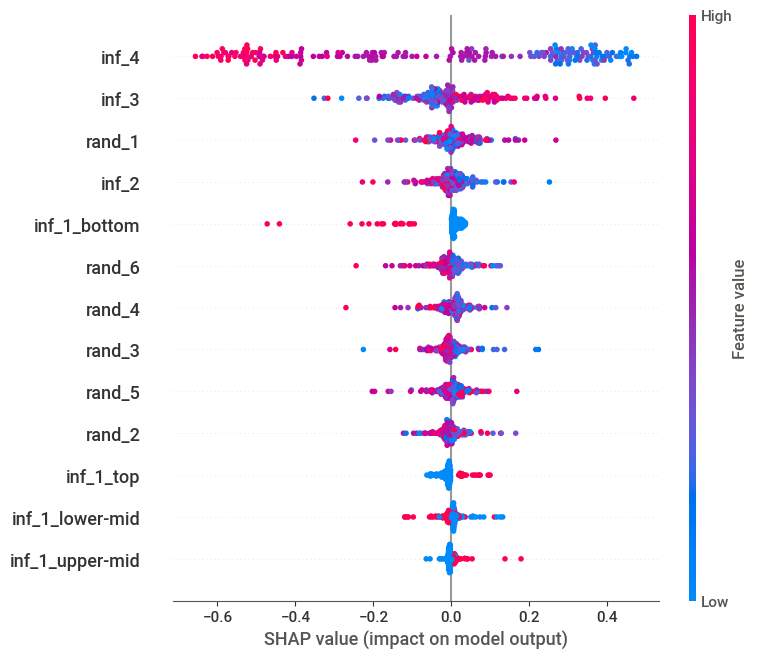

In [44]:
ml_pipeline.explain_model(X_test)

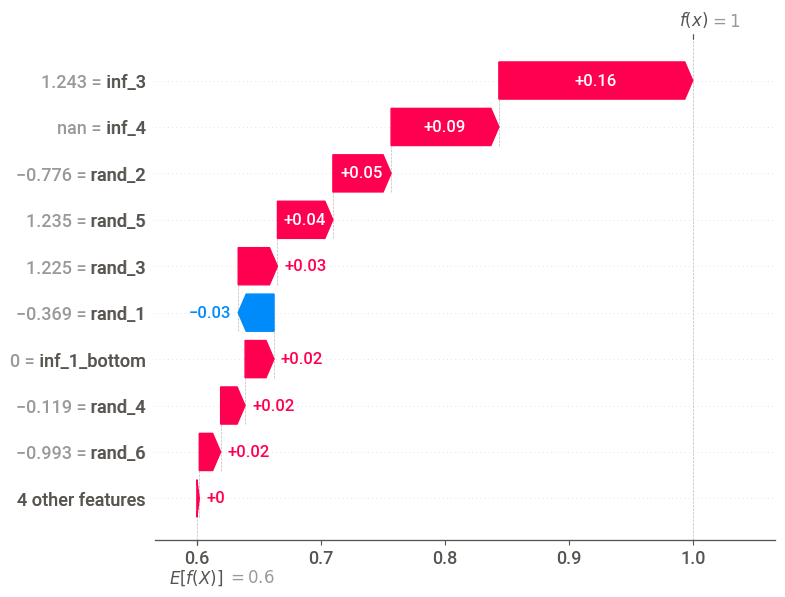

In [45]:
case_number = 8
ml_pipeline.explain_case(case_number)

### Test for Regression Problem

In [46]:
# Create a synthetic dataset for regression problem
n_feature = 10
n_inform = 4 
n_samples = 1000
X, y = make_regression(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, shuffle=False, random_state=12)
informative_features_names = [f'inf_{i+1}' for i in range(n_inform)]
random_features_names = [f'rand_{i+n_inform+1}' for i in range(n_feature - n_inform)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Switch to a regression algorithm
ml_pipeline = ML_PIPELINE(
    model = lgb.LGBMRegressor(verbose=-1),
    # model = RandomForestRegressor(),
    # model = xgb.XGBRegressor(),
    # model = SGDRegressor(),
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_pred = ml_pipeline.predict(None, X_test)


In [47]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f"rmse:{rmse:.2f}")

rmse:26.09


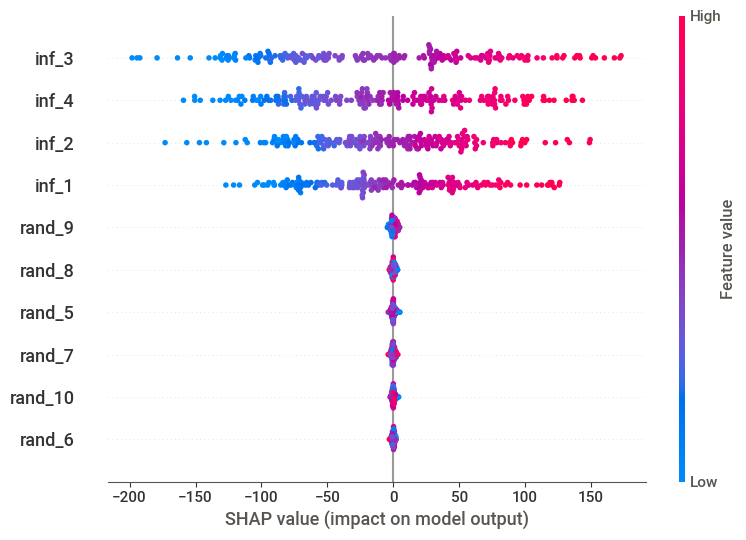

In [24]:
ml_pipeline.explain_model(X_test)

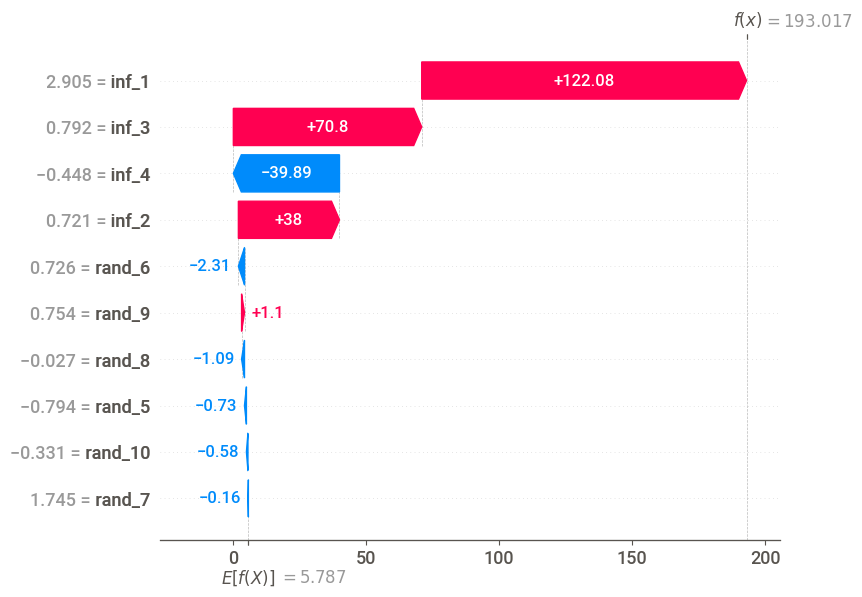

In [25]:
case_number = 5
ml_pipeline.explain_case(case_number)

## Log and use the ML Pipeline

2025/03/01 00:16:29 INFO mlflow.pyfunc: Inferring model signature from input example


Predictions match: True


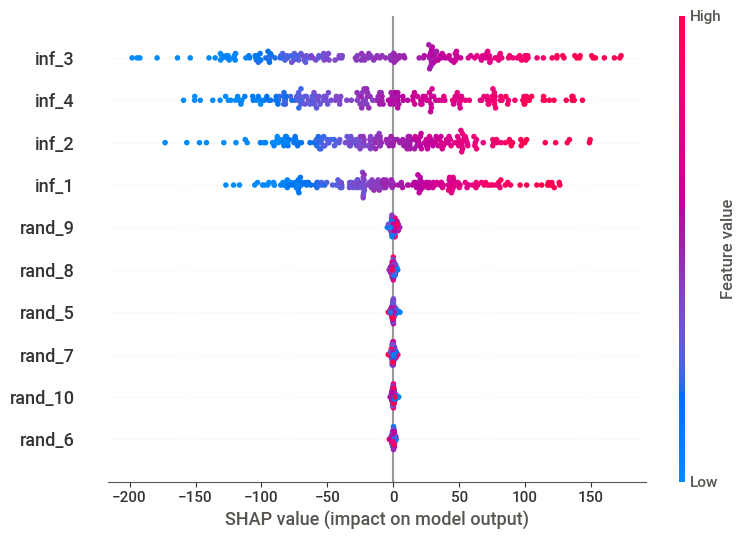

In [49]:
# Log the model with MLflow
with mlflow.start_run() as run:
    # Create input example using a small subset of test data
    input_example = pd.DataFrame(X_test[:5]) 

    # Log the custom model with auto-captured conda environment
    model_info = mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=ml_pipeline,
        conda_env=mlflow.sklearn.get_default_conda_env(),
        input_example=input_example  
    )
    
    mlflow.log_params(ml_pipeline.model.get_params())   
    mlflow.log_metric("rmse", rmse)      
    run_id = run.info.run_id

# Load the logged model
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

# Make predictions with loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Verify predictions match
print("Predictions match:", np.allclose(y_pred, y_pred_loaded))

# Draw explanatory plot with the unwrapped ml_pipeline
loaded_ml_pipeline = loaded_model.unwrap_python_model()
loaded_ml_pipeline.explain_model(X_test)